In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.preprocessing import PowerTransformer

In [119]:
# データ読み込み
train = pd.read_csv('./input/train.csv')
test = pd.read_csv('./input/test.csv', index_col='id')
df = pd.concat([train, test], ignore_index=True)
df.reset_index(drop=True, inplace=True)

In [121]:
#目的変数を対数変換
#予測時に戻すのを忘れないようにする
def transferY(df):
    p01 = df.y.quantile(0.01)
    p99 = df.y.quantile(0.99)
    df.y = df.y.clip(p01, p99)

    df.y = df.y.map(lambda x: np.log1p(x))
transferY(df)

In [122]:
#日付データの調整
def transferDatetime(df):
    def timedelta_hostsince(x):
        return (x - df['host_since'].min()).days
    def timedelta_lastreview(x):
        return (x - df['last_review'].min()).days
    def timedelta_firstreview(x):
        return (x - df['first_review'].min()).days
    df.host_since = pd.to_datetime(df['host_since'])
    df.last_review = pd.to_datetime(df['last_review'])
    df.first_review = pd.to_datetime(df['first_review'])
    
    df.host_since = df.host_since.map(lambda x: timedelta_hostsince(x))
    df.last_review = df.last_review.map(lambda x: timedelta_lastreview(x))
    df.first_review = df.first_review.map(lambda x: timedelta_firstreview(x))
transferDatetime(df)

In [123]:
#nameをベクトル化
name_text = list(df.name)

# TfidfVectorizer
vec_tfidf = TfidfVectorizer()

# ベクトル化
X = vec_tfidf.fit_transform(name_text)

name_tfidf = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names_out())
#print('Vocabulary size: {}'.format(len(vec_tfidf.vocabulary_)))
#print('Vocabulary content: {}'.format(vec_tfidf.vocabulary_))

MemoryError: Unable to allocate 6.56 GiB for an array with shape (74111, 11884) and data type float64

In [ ]:
#descriptionをベクトル化
desc_text = list(df.description)

# TfidfVectorizer
vec_tfidf = TfidfVectorizer()

# ベクトル化
X = vec_tfidf.fit_transform(desc_text)

desc_tfidf = pd.DataFrame(X.toarray(), columns=vec_tfidf.get_feature_names_out())
#print('Vocabulary size: {}'.format(len(vec_tfidf.vocabulary_)))
#print('Vocabulary content: {}'.format(vec_tfidf.vocabulary_))

MemoryError: Unable to allocate 21.9 GiB for an array with shape (55583, 52797) and data type float64

In [ ]:
def amenities2onehot(df):
    def shapeAmenity(x):
        '''
        shape amenities as a list of amenities for each record
        '''
        tmp_str = x[1:-2]
        tmp_str = tmp_str.replace('"', '')
        tmp_str = tmp_str.replace("'", "")
        tmp_str = tmp_str.split(',')
        return tmp_str

    def makeAmenityOnehot(x:list,amenity_category:list) -> list:
        '''
        x: record of amenities formated as a list
        amenity_category: a list of amenities entire the table

        description:
            execute onehot encoding
            tmp order [dryer,free parking on premises, kitchen, smoke detector, TV, Washer, Wireless Internet....]
        '''
        category = [0 for i in range(len(amenity_category))]

        for i in x:
            for j in range(len(amenity_category)):
                if i == amenity_category[j]:
                    category[j] = 1

        return category

    #format amenities column
    df.amenities = df.amenities.map(shapeAmenity)

    #generate list of amenities
    amenity_dict = defaultdict(int)
    for i in list(df.amenities):
        for j in i:
            amenity_dict[j] += 1
    amenity_category = list(amenity_dict.keys())

    #make onehot-encoded list
    tmp_onehot = list()
    for k in df.amenities:
        tmp_onehot.append(makeAmenityOnehot(k,amenity_category))

    amenity_category_df = pd.DataFrame(tmp_onehot)
    #amenity_category_df = amenity_category_df.set_axis(amenity_category, axis = 1)

    return amenity_category_df

out_df = amenities2onehot()

<AxesSubplot:>

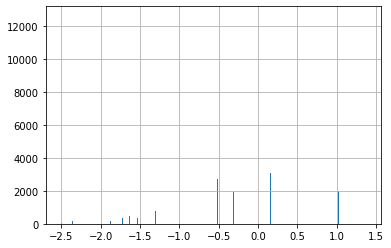

In [107]:
# review_scores_ratingを非線形処理
def review_scores_rating(df):
    padded = df.review_scores_rating.fillna(train.review_scores_rating.mean())
    pt = PowerTransformer(method = 'box-cox')
    pt.fit(np.array(padded).reshape(-1, 1) )
    df['review_scores_rating'] = pt.transform(np.array(padded).reshape(-1, 1))
review_scores_rating(train)
train.review_scores_rating.hist(bins = 1000)

In [118]:
train.property_type == 'Apartment'

0         True
1        False
2         True
3         True
4         True
         ...  
55578     True
55579     True
55580     True
55581    False
55582     True
Name: property_type, Length: 55583, dtype: bool